In [0]:
%tensorflow_version 2.x

In [329]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import pandas as pd

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.1.0


In [330]:
# Read the data file
#df = pd.read_csv("./SAS1.csv")
df = pd.read_csv("./daily_drinks_consumption.csv")
df.head(5)

,date,Latte,Iced Latte,Americano,Coffee,Iced Chai,Mocha,Chai Latte,Hot Chocolate,Iced Coffee,Cappuccino,Espresso,Cafe Au Lait,Steamed Milk,Black Tea,Iced Black Tea,Almond Milk Latte,Iced Caramel Latte Macchiato,Iced Caramel Latte,Pumpkin Spice Latte,Iced Vanilla Latte,Vanilla Latte,Iced Pumpkin Spice Latte,Caramel Latte Macchiato,Iced Dirty Chai,Vanilla Steamer,Dirty Chai,Skinny Hot Chocolate,Iced Almond Milk Latte,Mocha Macchiauto,Caramel Latte
0,6/18/2018,1,1,0,1,2,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6/19/2018,20,17,12,16,8,3,2,1,10,7,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6/20/2018,9,16,13,17,5,9,3,1,9,7,1,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6/21/2018,19,15,6,30,4,8,4,0,5,5,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6/22/2018,14,13,9,15,3,5,3,2,12,5,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [331]:
# Generate a Series
#drinks_amount = df['amount']
#drinks_amount.index = df['date']
drinks_amount = df['Latte']
drinks_amount.index = df['date']
drinks_amount.head()

date
6/18/2018     1
6/19/2018    20
6/20/2018     9
6/21/2018    19
6/22/2018    14
Name: Latte, dtype: int64

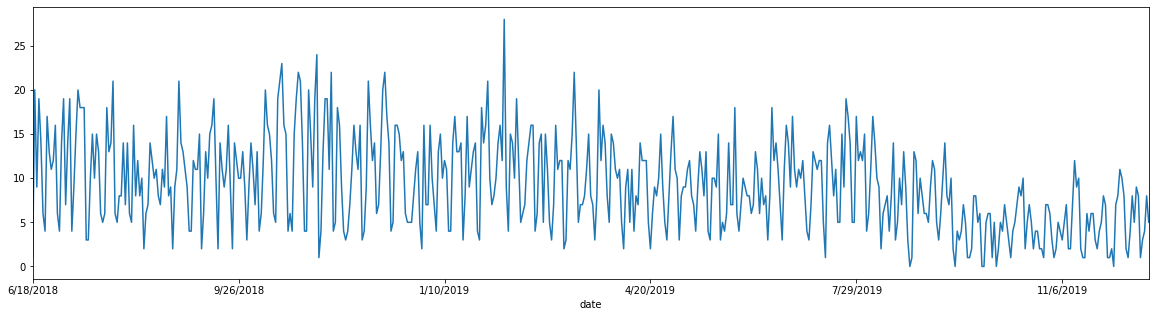

In [332]:
# Plot the daily drink amount 
drinks_amount.plot(figsize=(20, 5))

In [0]:
drinks_data = drinks_amount.values

In [334]:
# Get the mean and std of the traning dataset
TRAIN_SPLIT = 430
train_mean = drinks_data[:TRAIN_SPLIT].mean()
train_std = drinks_data[:TRAIN_SPLIT].std()
print(train_mean, train_std)

10.390697674418604 5.07853732621072


In [335]:
drinks_data = (drinks_data - train_mean) / train_std
drinks_data.shape

(543,)

In [0]:
def assembel_data(dataset, start_index, end_index, history_size, target_size, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i - history_size, i)    
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    if single_step:
        labels.append(dataset[i + target_size])
    else:
        labels.append(dataset[i: i + target_size])
  return np.array(data), np.array(labels)

In [0]:
# Assembel the data based on the history size and predicting size
history_size = 90
future_target = 14

x_train, y_train = assembel_data(drinks_data, 0, TRAIN_SPLIT, history_size, future_target)
x_val, y_val = assembel_data(drinks_data, TRAIN_SPLIT, None, history_size, future_target)


In [338]:
print("the size of the training set is: {}".format(x_train.shape[0])) # original 400
print("the size of the validation set is: {}".format(x_val.shape[0])) # origin 143
#print ('history data sample:\n{}'.format(x_val[1]))
#print ('target label sample:\n{}'.format(y_val[1]))

the size of the training set is: 340
the size of the validation set is: 9


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
BATCH_SIZE = 20
BUFFER_SIZE = 500

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [341]:
#multi step lstm model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.Dense(14))

#multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
optimizer = tf.keras.optimizers.SGD(lr=3e-3, momentum=0.9)
#multi_step_model.compile(optimizer=optimizer, loss='mae', metrics = ['accuracy'])
multi_step_model.compile(optimizer=optimizer, loss='mae')
multi_step_model.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 90, 32)            4352      
_________________________________________________________________
dropout_32 (Dropout)         (None, 90, 32)            0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_33 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 14)                462       
Total params: 13,134
Trainable params: 13,134
Non-trainable params: 0
_________________________________________________________________


In [342]:
#test, to guarantee the output shape is correct
for x, y in val_univariate.take(3):
  print (multi_step_model.predict(x).shape)

(9, 14)
(9, 14)
(9, 14)


In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.6):
            print("reached lessthan 0.5 so cancelling training!")
            self.model.stop_training = True

In [344]:
callbacks = myCallback()
# Train the model
#EVALUATION_INTERVAL = 200
EPOCHS = 500
EVALUATION_INTERVAL = math.ceil(len(drinks_data) / BATCH_SIZE)
print("EVALUATION_INTERVAL is:{}".format(EVALUATION_INTERVAL))



EVALUATION_INTERVAL is:28


In [0]:
multi_step_history = multi_step_model.fit(train_univariate, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_univariate,
                                          validation_steps=50, 
                                          callbacks=[callbacks])

Train for 28 steps, validate for 50 steps
Epoch 1/500
28/28 [==============================] - 6s 198ms/step - loss: 0.8226 - val_loss: 0.9572
Epoch 2/500
28/28 [==============================] - 3s 114ms/step - loss: 0.8268 - val_loss: 0.9540
Epoch 3/500
28/28 [==============================] - 3s 115ms/step - loss: 0.8245 - val_loss: 0.9511
Epoch 4/500
28/28 [==============================] - 3s 118ms/step - loss: 0.8216 - val_loss: 0.9481
Epoch 5/500
28/28 [==============================] - 3s 117ms/step - loss: 0.8308 - val_loss: 0.9452
Epoch 6/500
28/28 [==============================] - 3s 120ms/step - loss: 0.8179 - val_loss: 0.9421
Epoch 7/500
28/28 [==============================] - 3s 114ms/step - loss: 0.8300 - val_loss: 0.9393
Epoch 8/500
28/28 [==============================] - 3s 111ms/step - loss: 0.8154 - val_loss: 0.9364
Epoch 9/500
28/28 [==============================] - 3s 111ms/step - loss: 0.8292 - val_loss: 0.9336
Epoch 10/500
28/28 [=============================

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.show()
  #plt.savefig('temp.png', dpi=fig.dpi)

plot_train_history(multi_step_history, "loss")

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(20, 5))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), 'go--', linewidth=2, markersize=5, label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo--', label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'r*--', label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [0]:
# Plot the true value and predicted value
for x, y in val_univariate.take(1):
    for i in range(len(x)):
        multi_step_plot(x[i], y[i], multi_step_model.predict(x)[i])


In [0]:
# Evaluation
# The MAPE (Mean Absolute Percent Error) measures the size of the error in percentage terms.
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


In [0]:
def evaluation(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    '''
    print('R^2   test: %.2f' % r2_score(y_true, y_pred))
    print('MSE   test: %.2f' % mean_squared_error(y_true, y_pred))
    print('RMSE  test: %.2f' % np.sqrt(mean_squared_error(y_true, y_pred)))
    print('MAE   test: %.2f' % mean_absolute_error(y_true, y_pred))
    '''


In [0]:
def multi_step_plot1(history, true_future, prediction):
  plt.figure(figsize=(20, 5))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), 'go--', linewidth=2, markersize=5, label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo--', label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'r*--', label='Predicted Future')
  #
  plt.grid(True)
  plt.show()

In [0]:
# Plot the true value and predicted value
for x, y in val_univariate.take(1):
    for i in range(len(x)):
        multi_step_plot1((drinks_data[-104:-14] * train_std + train_mean), (y[i] * train_std + train_mean), 
                        (multi_step_model.predict(x)[i] * train_std + train_mean))

In [0]:
score = []
for x, y in val_univariate.take(1):
    for i in range(len(x)):
        mape = evaluation((y[i] * train_std + train_mean), (multi_step_model.predict(x)[i] * train_std + train_mean))
        score.append(mape)
        print(mape)
print("MAPA is:{}".format(100 - sum(score) / len(score)))